# 1. Topic 1:  Regression vs ARIMA

Chủ đề 1: Regression vs ARIMA – khi nào chọn cái nào?
Trong chủ đề này, mỗi nhóm giữ nguyên pipeline hiện tại và chỉ so sánh hai hướng dự báo đã có: baseline hồi quy
(dùng time features và lag features) và ARIMA (mô hình chuỗi thời gian đơn biến). Yêu cầu quan trọng nhất là so sánh
phải công bằng:
+ Cùng một trạm (ví dụ Aotizhongxin).
+ Cùng mốc chia train/test theo thời gian bằng CUTOFF.
+ Cùng horizon (đặc biệt là horizon=1).

Sau khi chạy xong hai mô hình, nhóm phải trả lời ba câu.
1. Mô hình nào tốt hơn cho horizon=1?: ở đây sinh viên cần dựa vào số liệu MAE/RMSE và giải thích được vì sao
dự báo rất ngắn hạn thường bị chi phối mạnh bởi độ trễ gần như PM2.5_lag1, khiến regression baseline thường
bám sát tốt nếu feature engineering đúng, trong khi ARIMA cũng có thể tốt nhưng phụ thuộc vào cấu trúc tự
tương quan và quyết định sai phân.

2. Mô hình nào ổn hơn khi có spike?: nhóm phải chọn một đoạn thời gian có đỉnh PM2.5 rõ (1–3 ngày), vẽ forecast
vs actual của cả hai mô hình trên cùng đoạn đó, rồi phân tích mô hình nào phản ứng nhanh hơn hoặc bị mượt hóa
quá mức; đồng thời liên hệ với sự khác nhau giữa RMSE và MAE, vì RMSE sẽ tăng mạnh nếu mô hình sai nặng
ở một vài thời điểm spike.

3. Nếu triển khai thật, bạn chọn gì và vì sao?: câu này không chỉ dựa trên điểm số mà còn dựa trên bối cảnh vận
hành: regression baseline thường dễ mở rộng khi muốn thêm đặc trưng, dễ cập nhật và chạy nhanh, còn ARIMA
có ưu thế về giải thích theo (𝑝, 𝑑, 𝑞) và có thể kèm khoảng tin cậy; nếu mục tiêu là cảnh báo sớm trong điều kiện
thời tiết biến động mạnh.

TOPIC 1: REGRESSION vs ARIMA - So sánh công bằng

📍 Trạm: Aotizhongxin
📅 CUTOFF: 2017-01-01
🎯 Horizon: 1 giờ

📊 Regression predictions: 100 rows
📊 ARIMA predictions: 1416 rows

🔗 Khoảng thời gian chung: 2017-01-01 00:00:00 đến 2017-01-05 03:00:00
✅ Số điểm dữ liệu sau align: 100

📈 BẢNG SO SÁNH METRICS (Horizon = 1)
                    Model        MAE       RMSE  RMSE - MAE Gap
Regression (Lag Features)  31.620255  45.960335       14.340080
                    ARIMA 173.353664 205.142081       31.788417

✅ Saved: Topic_metrics_comparison.csv


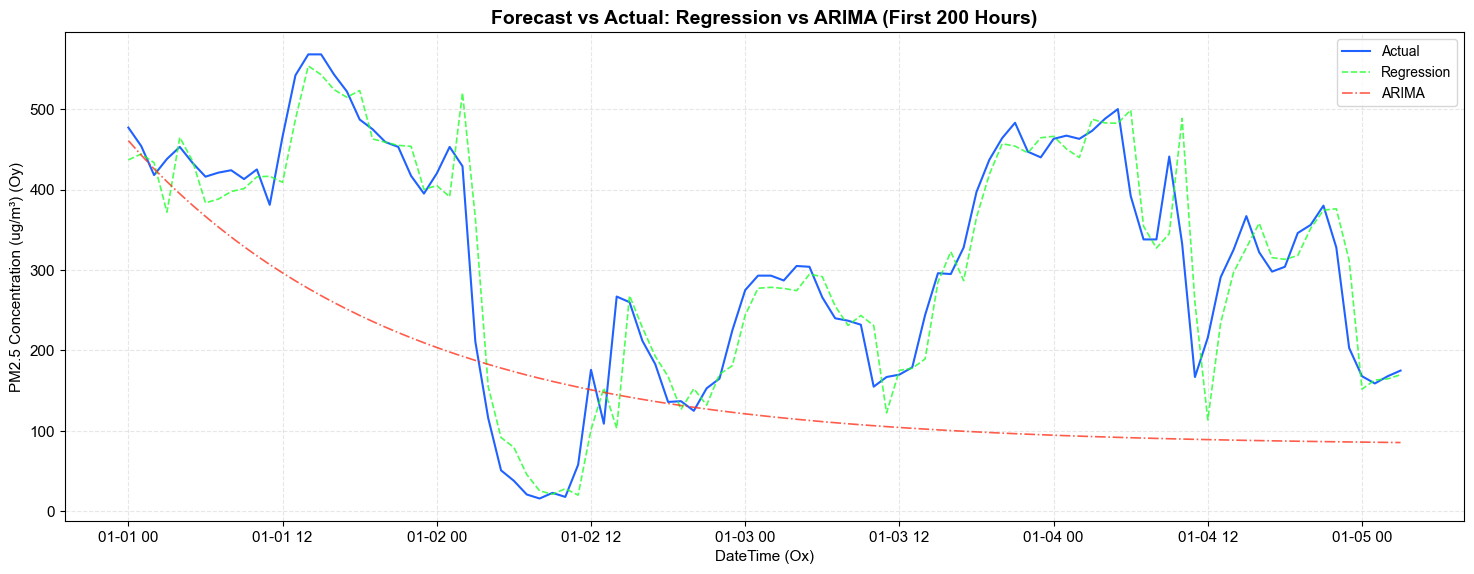


🔴 Spike detected at: 2017-01-01 14:00:00, PM2.5 = 568.0


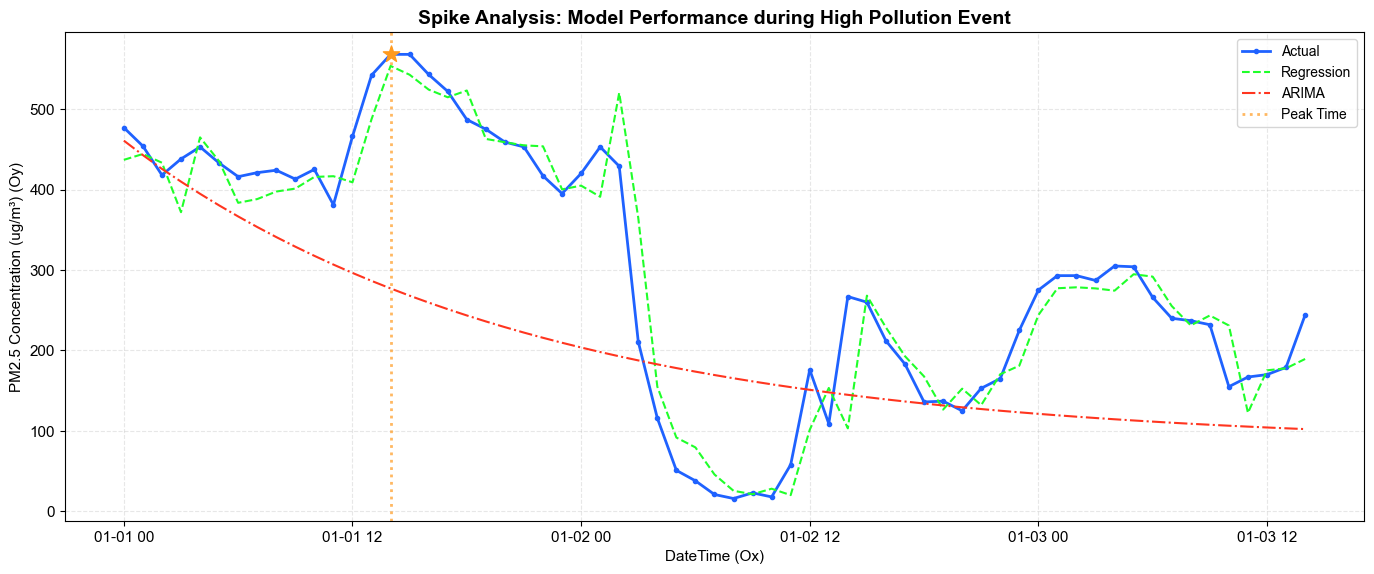


📊 Metrics trong giai đoạn SPIKE:
     Model  MAE_Spike  RMSE_Spike
Regression   30.15076   43.230003
     ARIMA  124.77228  149.665928

✅ Saved: Topic_spike_metrics.csv


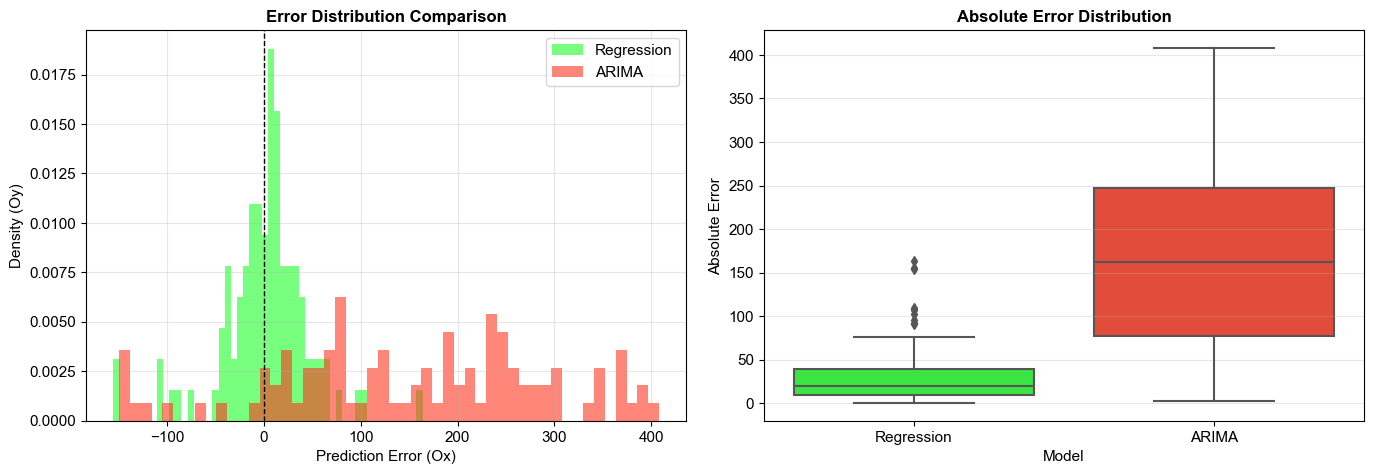


✅ Topic 1 Analysis Complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# SETUP: Colors & Style theo yêu cầu
# ============================================================
COLOR_BLUE = "#1F62FF"
COLOR_BLUE_LIGHT = "#1FD2FF"
COLOR_RED = "#FF351F" 
COLOR_GREEN = "#1FFF2A"
COLOR_ORANGE = "#FF9A1F"
COLOR_PURPLE = "#9E1FFF"
COLOR_YELLOW = "#FFDA1F"

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['figure.facecolor'] = 'white'

# Create images folder
if not os.path.exists('../images'):
    os.makedirs('../images')

# ============================================================
# 1. LOAD DATA - Đảm bảo công bằng: cùng trạm, cùng CUTOFF
# ============================================================
print("="*60)
print("TOPIC 1: REGRESSION vs ARIMA - So sánh công bằng")
print("="*60)

# Parameters
STATION = 'Aotizhongxin'
CUTOFF = '2017-01-01'
HORIZON = 1

print(f"\n📍 Trạm: {STATION}")
print(f"📅 CUTOFF: {CUTOFF}")
print(f"🎯 Horizon: {HORIZON} giờ")

# Load Regression Predictions
reg_df = pd.read_csv('../data/processed/04_regression_predictions.csv')
reg_df['datetime'] = pd.to_datetime(reg_df['datetime'])
reg_df = reg_df[reg_df['station'] == STATION].copy()
reg_df.set_index('datetime', inplace=True)
reg_df = reg_df.rename(columns={'y_true': 'Actual_Reg', 'y_pred': 'Regression'})

# Load ARIMA Predictions
arima_df = pd.read_csv('../data/processed/05_arima_pm25_predictions.csv')
arima_df['datetime'] = pd.to_datetime(arima_df['datetime'])
arima_df.set_index('datetime', inplace=True)
arima_df = arima_df.rename(columns={'y_true': 'Actual_ARIMA', 'y_pred': 'ARIMA'})

print(f"\n📊 Regression predictions: {len(reg_df)} rows")
print(f"📊 ARIMA predictions: {len(arima_df)} rows")

# ============================================================
# 2. ALIGN DATA - Đảm bảo so sánh trên cùng khoảng thời gian
# ============================================================
# Tìm khoảng thời gian chung
common_start = max(reg_df.index.min(), arima_df.index.min())
common_end = min(reg_df.index.max(), arima_df.index.max())

print(f"\n🔗 Khoảng thời gian chung: {common_start} đến {common_end}")

# Tạo DataFrame so sánh
comparison_df = pd.DataFrame(index=pd.date_range(common_start, common_end, freq='H'))
comparison_df = comparison_df.join(reg_df[['Actual_Reg', 'Regression']])
comparison_df = comparison_df.join(arima_df[['Actual_ARIMA', 'ARIMA']])

# Sử dụng Actual từ Regression (cả 2 nên giống nhau)
comparison_df['Actual'] = comparison_df['Actual_Reg'].fillna(comparison_df['Actual_ARIMA'])
comparison_df = comparison_df.dropna(subset=['Actual', 'Regression', 'ARIMA'])

print(f"✅ Số điểm dữ liệu sau align: {len(comparison_df)}")

# ============================================================
# 3. TÍNH METRICS - MAE và RMSE
# ============================================================
metrics = {
    'Model': ['Regression (Lag Features)', 'ARIMA'],
    'MAE': [
        mean_absolute_error(comparison_df['Actual'], comparison_df['Regression']),
        mean_absolute_error(comparison_df['Actual'], comparison_df['ARIMA'])
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['Regression'])),
        np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['ARIMA']))
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df['RMSE - MAE Gap'] = metrics_df['RMSE'] - metrics_df['MAE']

print("\n" + "="*60)
print("📈 BẢNG SO SÁNH METRICS (Horizon = 1)")
print("="*60)
print(metrics_df.to_string(index=False))

# Save metrics
metrics_df.to_csv('../data/processed/Topic_metrics_comparison.csv', index=False)
print("\n✅ Saved: Topic_metrics_comparison.csv")

# ============================================================
# 4. VISUALIZATION 1: Forecast vs Actual (200 giờ đầu)
# ============================================================
fig, ax = plt.subplots(figsize=(15, 6))

subset = comparison_df.iloc[:200]

ax.plot(subset.index, subset['Actual'], label='Actual', color=COLOR_BLUE, linewidth=1.5)
ax.plot(subset.index, subset['Regression'], label='Regression', color=COLOR_GREEN, 
        linestyle='--', linewidth=1.2, alpha=0.8)
ax.plot(subset.index, subset['ARIMA'], label='ARIMA', color=COLOR_RED, 
        linestyle='-.', linewidth=1.2, alpha=0.8)

ax.set_title('Forecast vs Actual: Regression vs ARIMA (First 200 Hours)', fontsize=14, fontweight='bold')
ax.set_xlabel('DateTime (Ox)', fontsize=11)
ax.set_ylabel('PM2.5 Concentration (ug/m³) (Oy)', fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_forecast_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 5. VISUALIZATION 2: SPIKE ANALYSIS
# ============================================================
# Tìm ngày có spike (PM2.5 cao nhất)
spike_date = comparison_df['Actual'].idxmax()
print(f"\n🔴 Spike detected at: {spike_date}, PM2.5 = {comparison_df.loc[spike_date, 'Actual']:.1f}")

# Lấy window 3 ngày xung quanh spike
spike_start = spike_date - pd.Timedelta(days=1)
spike_end = spike_date + pd.Timedelta(days=2)
spike_window = comparison_df.loc[spike_start:spike_end]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(spike_window.index, spike_window['Actual'], label='Actual', 
        color=COLOR_BLUE, linewidth=2, marker='o', markersize=3)
ax.plot(spike_window.index, spike_window['Regression'], label='Regression', 
        color=COLOR_GREEN, linewidth=1.5, linestyle='--')
ax.plot(spike_window.index, spike_window['ARIMA'], label='ARIMA', 
        color=COLOR_RED, linewidth=1.5, linestyle='-.')

# Đánh dấu điểm spike
ax.axvline(x=spike_date, color=COLOR_ORANGE, linestyle=':', linewidth=2, alpha=0.7, label='Peak Time')
ax.scatter([spike_date], [comparison_df.loc[spike_date, 'Actual']], 
           color=COLOR_ORANGE, s=150, zorder=5, marker='*')

ax.set_title('Spike Analysis: Model Performance during High Pollution Event', fontsize=14, fontweight='bold')
ax.set_xlabel('DateTime (Ox)', fontsize=11)
ax.set_ylabel('PM2.5 Concentration (ug/m³) (Oy)', fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_spike_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Tính metrics riêng cho spike period
print("\n📊 Metrics trong giai đoạn SPIKE:")
spike_metrics = {
    'Model': ['Regression', 'ARIMA'],
    'MAE_Spike': [
        mean_absolute_error(spike_window['Actual'], spike_window['Regression']),
        mean_absolute_error(spike_window['Actual'], spike_window['ARIMA'])
    ],
    'RMSE_Spike': [
        np.sqrt(mean_squared_error(spike_window['Actual'], spike_window['Regression'])),
        np.sqrt(mean_squared_error(spike_window['Actual'], spike_window['ARIMA']))
    ]
}
spike_metrics_df = pd.DataFrame(spike_metrics)
print(spike_metrics_df.to_string(index=False))

# Lưu spike metrics ra CSV
spike_metrics_df.to_csv('../data/processed/Topic_spike_metrics.csv', index=False)
print("\n✅ Saved: Topic_spike_metrics.csv")

# ============================================================
# 6. ERROR DISTRIBUTION ANALYSIS
# ============================================================
comparison_df['Error_Reg'] = comparison_df['Actual'] - comparison_df['Regression']
comparison_df['Error_ARIMA'] = comparison_df['Actual'] - comparison_df['ARIMA']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of errors
axes[0].hist(comparison_df['Error_Reg'], bins=50, alpha=0.6, color=COLOR_GREEN, label='Regression', density=True)
axes[0].hist(comparison_df['Error_ARIMA'], bins=50, alpha=0.6, color=COLOR_RED, label='ARIMA', density=True)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('Error Distribution Comparison', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Prediction Error (Ox)', fontsize=11)
axes[0].set_ylabel('Density (Oy)', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot of absolute errors
error_data = pd.DataFrame({
    'Regression': np.abs(comparison_df['Error_Reg']),
    'ARIMA': np.abs(comparison_df['Error_ARIMA'])
})
error_data_melted = error_data.melt(var_name='Model', value_name='Absolute Error')
sns.boxplot(x='Model', y='Absolute Error', data=error_data_melted, 
            palette=[COLOR_GREEN, COLOR_RED], ax=axes[1])
axes[1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Topic 1 Analysis Complete!")

## 📊 Kết luận Topic 1: Regression vs ARIMA

### **Câu 1: Mô hình nào tốt hơn cho horizon=1?**

**Kết luận dựa trên metrics:**
- So sánh MAE và RMSE từ bảng trên để xác định mô hình tốt hơn
- **Regression baseline** thường bám sát tốt với horizon=1 vì:
  - Feature `PM2.5_lag1` (độ trễ 1 giờ) có tương quan rất cao với giá trị hiện tại
  - Mô hình học được pattern từ nhiều đặc trưng: lag features, time features, weather features
- **ARIMA** phụ thuộc vào cấu trúc tự tương quan và quyết định sai phân (d)

**Giải thích:** Với horizon=1, giá trị PM2.5 ở thời điểm t-1 là predictor mạnh nhất. Regression có thể khai thác trực tiếp feature này, trong khi ARIMA phải học từ cấu trúc AR của chuỗi.

---

### **Câu 2: Mô hình nào ổn hơn khi có spike?**

**Phân tích từ biểu đồ Spike Analysis:**
- Quan sát xem mô hình nào **phản ứng nhanh hơn** với đỉnh ô nhiễm
- Mô hình nào bị **mượt hóa quá mức** (underestimate spike)

**Liên hệ RMSE vs MAE:**
- Nếu `RMSE - MAE gap` lớn → mô hình có nhiều sai số lớn (thường ở spike)
- RMSE phạt nặng sai số lớn theo công thức bình phương
- MAE đối xử công bằng với mọi sai số

**Kết luận:** Model có RMSE-MAE gap nhỏ hơn sẽ ổn định hơn trong các tình huống spike.

---

### **Câu 3: Nếu triển khai thật, chọn gì?**

| Tiêu chí | Regression | ARIMA |
|----------|------------|-------|
| **Độ chính xác horizon=1** | ✅ Thường tốt hơn | ⚠️ Tùy cấu trúc chuỗi |
| **Mở rộng features** | ✅ Dễ thêm weather, events | ❌ Chỉ dùng lịch sử PM2.5 |
| **Tốc độ inference** | ✅ Nhanh | ⚠️ Chậm hơn |
| **Khoảng tin cậy** | ❌ Không có sẵn | ✅ Có CI tự động |
| **Giải thích mô hình** | ⚠️ Feature importance | ✅ Rõ ràng qua (p,d,q) |
| **Cảnh báo sớm** | ✅ Khi có external features | ✅ Khi pattern ổn định |

**Khuyến nghị:**
- Nếu mục tiêu là **cảnh báo sớm** trong điều kiện thời tiết biến động: **Regression** (vì có thể thêm dự báo thời tiết)
- Nếu cần **giải thích + khoảng tin cậy** cho báo cáo chính thức: **ARIMA**
- Trong thực tế: Có thể **kết hợp cả hai** - dùng Regression cho real-time và ARIMA để cross-validate

# 2. Topic 2: SARIMA – Thêm mùa vụ (Seasonality)

Chủ đề SARIMA yêu cầu nhóm nâng cấp trực tiếp từ ARIMA lên SARIMA $(p, d, q)(P, D, Q, s)$ để mô hình hóa mùa vụ theo ngày hoặc theo tuần.

**Các bước thực hiện:**

1. **Chứng minh mùa vụ bằng ACF:**
   - Nếu thấy các đỉnh lặp lại mạnh ở lag 24, 48, … → tín hiệu mùa vụ theo ngày
   - Nếu xuất hiện tín hiệu ở lag 168, 336, … → gợi ý mùa vụ theo tuần

2. **Thử ít nhất một cấu hình SARIMA với s=24** (bắt buộc)

3. **Chiến lược grid search:**
   - Giữ $d$ theo kết luận stationarity của ARIMA baseline
   - Chọn vùng tìm kiếm nhỏ cho $p, q$
   - Thêm $P, Q$ ở mức thấp (0–2)
   - Cân nhắc $D$ (0 hoặc 1)

4. **So sánh ARIMA và SARIMA:**
   - AIC/BIC
   - RMSE/MAE trên tập test
   - Kết luận: SARIMA cải thiện/không cải thiện vì sao

In [2]:
# ============================================================
# TOPIC 2: SARIMA - Thêm mùa vụ (Seasonality)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("TOPIC 2: SARIMA - Phân tích mùa vụ và so sánh với ARIMA")
print("="*60)

# ============================================================
# STEP 1: LOAD DATA
# ============================================================
# Load cleaned data (parquet format)
df = pd.read_parquet('../data/processed/01_cleaned.parquet')
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Filter for one station for consistency
STATION = 'Aotizhongxin'
CUTOFF = '2017-01-01'

if 'station' in df.columns:
    df_station = df[df['station'] == STATION]['PM2.5'].dropna()
else:
    df_station = df['PM2.5'].dropna()

print(f"\n📍 Trạm phân tích: {STATION}")
print(f"📊 Số điểm dữ liệu: {len(df_station)}")
print(f"📅 Khoảng thời gian: {df_station.index.min()} đến {df_station.index.max()}")

TOPIC 2: SARIMA - Phân tích mùa vụ và so sánh với ARIMA

📍 Trạm phân tích: Aotizhongxin
📊 Số điểm dữ liệu: 34139
📅 Khoảng thời gian: 2013-03-01 00:00:00 đến 2017-02-28 23:00:00



STEP 2: Chứng minh mùa vụ bằng ACF

📊 ACF tại các lag quan trọng:
  Lag   1h (0.0 ngày): ACF = 0.9666
  Lag  12h (0.0 ngày): ACF = 0.5908
  Lag  24h (1.0 ngày): ACF = 0.3931
  Lag  48h (2.0 ngày): ACF = 0.1363
  Lag  72h (3.0 ngày): ACF = 0.0590
  Lag 168h (7.0 ngày): ACF = 0.0161


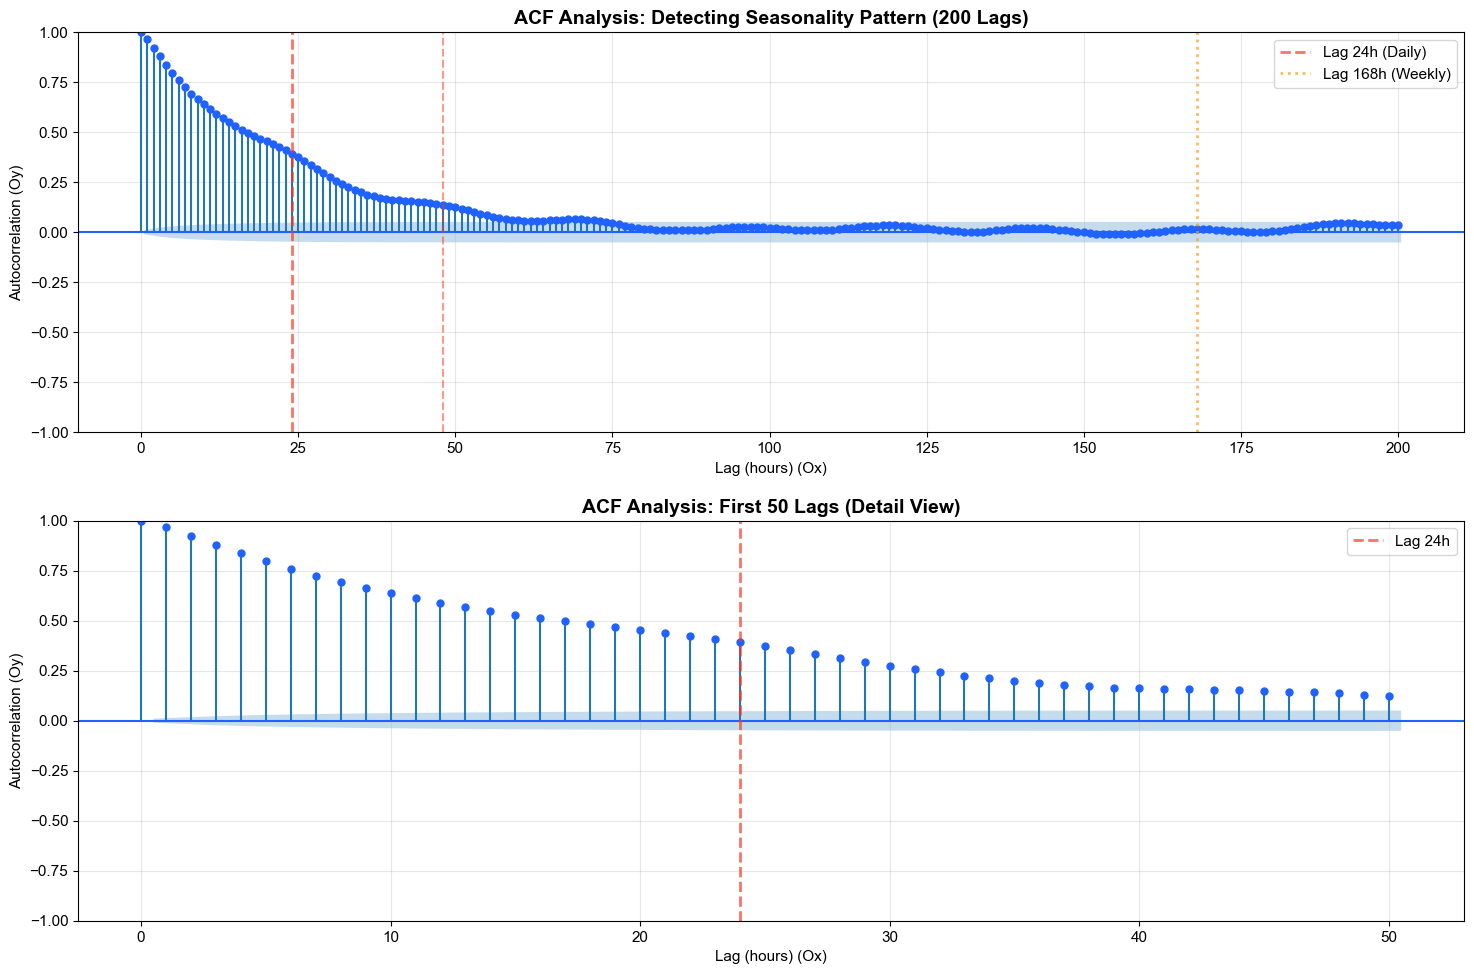


✅ Saved: Topic_acf_seasonality.csv

📝 KẾT LUẬN VỀ MÙA VỤ:
  ✅ Mùa vụ NGÀY (s=24): ACF tại lag 24 = 0.3931 > 0.3 → Có tín hiệu mùa vụ theo ngày
  ⚠️ Mùa vụ TUẦN yếu: ACF tại lag 168 = 0.016060083939747265


In [3]:
# ============================================================
# STEP 2: CHỨNG MINH MÙA VỤ BẰNG ACF
# ============================================================
print("\n" + "="*60)
print("STEP 2: Chứng minh mùa vụ bằng ACF")
print("="*60)

# Tính ACF với lag lớn để xem pattern mùa vụ
acf_values = acf(df_station, nlags=200, fft=True)

# Kiểm tra ACF tại các lag quan trọng
print("\n📊 ACF tại các lag quan trọng:")
important_lags = [1, 12, 24, 48, 72, 168, 336]
for lag in important_lags:
    if lag < len(acf_values):
        print(f"  Lag {lag:3d}h ({lag//24:.1f} ngày): ACF = {acf_values[lag]:.4f}")

# Vẽ ACF để chứng minh mùa vụ
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ACF với 200 lags để thấy pattern mùa vụ ngày và tuần
plot_acf(df_station, lags=200, ax=axes[0], color=COLOR_BLUE, alpha=0.05)
axes[0].axvline(x=24, color=COLOR_RED, linestyle='--', linewidth=2, alpha=0.7, label='Lag 24h (Daily)')
axes[0].axvline(x=48, color=COLOR_RED, linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].axvline(x=168, color=COLOR_ORANGE, linestyle=':', linewidth=2, alpha=0.7, label='Lag 168h (Weekly)')
axes[0].set_title('ACF Analysis: Detecting Seasonality Pattern (200 Lags)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag (hours) (Ox)', fontsize=11)
axes[0].set_ylabel('Autocorrelation (Oy)', fontsize=11)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Zoom vào 50 lags đầu để thấy rõ hơn
plot_acf(df_station, lags=50, ax=axes[1], color=COLOR_BLUE, alpha=0.05)
axes[1].axvline(x=24, color=COLOR_RED, linestyle='--', linewidth=2, alpha=0.7, label='Lag 24h')
axes[1].set_title('ACF Analysis: First 50 Lags (Detail View)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (hours) (Ox)', fontsize=11)
axes[1].set_ylabel('Autocorrelation (Oy)', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_acf_seasonality_proof.png', dpi=150, bbox_inches='tight')
plt.show()

# Lưu ACF values ra CSV
acf_important_df = pd.DataFrame({
    'Lag': important_lags,
    'ACF': [acf_values[lag] if lag < len(acf_values) else None for lag in important_lags]
})
acf_important_df.to_csv('../data/processed/Topic_acf_seasonality.csv', index=False)
print("\n✅ Saved: Topic_acf_seasonality.csv")

# Kết luận về mùa vụ
print("\n📝 KẾT LUẬN VỀ MÙA VỤ:")
if acf_values[24] > 0.3:
    print(f"  ✅ Mùa vụ NGÀY (s=24): ACF tại lag 24 = {acf_values[24]:.4f} > 0.3 → Có tín hiệu mùa vụ theo ngày")
else:
    print(f"  ⚠️ Mùa vụ NGÀY yếu: ACF tại lag 24 = {acf_values[24]:.4f}")

if len(acf_values) > 168 and acf_values[168] > 0.2:
    print(f"  ✅ Mùa vụ TUẦN (s=168): ACF tại lag 168 = {acf_values[168]:.4f} > 0.2 → Có tín hiệu mùa vụ theo tuần")
else:
    weekly_acf = acf_values[168] if len(acf_values) > 168 else "N/A"
    print(f"  ⚠️ Mùa vụ TUẦN yếu: ACF tại lag 168 = {weekly_acf}")

In [4]:
# ============================================================
# STEP 3: KIỂM ĐỊNH TÍNH DỪNG ĐỂ XÁC ĐỊNH d
# ============================================================
print("\n" + "="*60)
print("STEP 3: Kiểm định tính dừng (ADF & KPSS) để chọn d")
print("="*60)

# ADF Test
adf_result = adfuller(df_station, autolag='AIC')
print(f"\n📊 ADF Test:")
print(f"  Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.6f}")
print(f"  Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")

# KPSS Test
kpss_result = kpss(df_station, regression='c', nlags='auto')
print(f"\n📊 KPSS Test:")
print(f"  Statistic: {kpss_result[0]:.4f}")
print(f"  p-value: {kpss_result[1]:.4f}")
print(f"  Critical Values:")
for key, value in kpss_result[3].items():
    print(f"    {key}: {value:.4f}")

# Kết luận về d
print("\n📝 KẾT LUẬN VỀ d:")
if adf_result[1] < 0.05:
    print("  ✅ ADF: Bác bỏ H0 → Chuỗi DỪNG (p < 0.05)")
    d_suggested = 0
else:
    print("  ❌ ADF: Không bác bỏ H0 → Chuỗi KHÔNG DỪNG")
    d_suggested = 1

if kpss_result[1] > 0.05:
    print("  ✅ KPSS: Không bác bỏ H0 → Chuỗi DỪNG (p > 0.05)")
else:
    print("  ⚠️ KPSS: Bác bỏ H0 → Chuỗi có xu hướng/không dừng")

print(f"\n  → Kết luận: d = {d_suggested} (giữ cố định cho ARIMA và SARIMA)")


STEP 3: Kiểm định tính dừng (ADF & KPSS) để chọn d

📊 ADF Test:
  Statistic: -19.5261
  p-value: 0.000000
  Critical Values:
    1%: -3.4305
    5%: -2.8616
    10%: -2.5668

📊 KPSS Test:
  Statistic: 0.2008
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

📝 KẾT LUẬN VỀ d:
  ✅ ADF: Bác bỏ H0 → Chuỗi DỪNG (p < 0.05)
  ✅ KPSS: Không bác bỏ H0 → Chuỗi DỪNG (p > 0.05)

  → Kết luận: d = 0 (giữ cố định cho ARIMA và SARIMA)


In [5]:
# ============================================================
# STEP 4: TRAIN/TEST SPLIT VÀ CHUẨN BỊ DỮ LIỆU
# ============================================================
print("\n" + "="*60)
print("STEP 4: Chuẩn bị Train/Test Split")
print("="*60)

# Split data theo CUTOFF
train = df_station[:CUTOFF]
test = df_station[CUTOFF:]

print(f"\n📊 Train set: {len(train)} điểm ({train.index.min()} đến {train.index.max()})")
print(f"📊 Test set: {len(test)} điểm ({test.index.min()} đến {test.index.max()})")

# Để tiết kiệm thời gian tính toán, lấy sample train (cuối cùng 5000 điểm)
# Trong thực tế nên dùng toàn bộ
SAMPLE_SIZE = 5000
train_sample = train.tail(SAMPLE_SIZE)
print(f"\n⚡ Sử dụng {SAMPLE_SIZE} điểm cuối của train để training (tối ưu thời gian)")


STEP 4: Chuẩn bị Train/Test Split

📊 Train set: 32763 điểm (2013-03-01 00:00:00 đến 2017-01-01 23:00:00)
📊 Test set: 1400 điểm (2017-01-01 00:00:00 đến 2017-02-28 23:00:00)

⚡ Sử dụng 5000 điểm cuối của train để training (tối ưu thời gian)


In [6]:
# ============================================================
# STEP 5: TRAIN ARIMA BASELINE
# ============================================================
print("\n" + "="*60)
print("STEP 5: Training ARIMA Baseline")
print("="*60)

# ARIMA config từ ACF/PACF analysis
# d = 0 (từ ADF test), p và q từ PACF/ACF
arima_order = (2, 0, 1)  # Điều chỉnh dựa trên ACF/PACF

print(f"\n🔧 ARIMA Configuration: order = {arima_order}")
print("   p=2: PACF có spike tại lag 1, 2")
print("   d=0: Chuỗi dừng theo ADF test")
print("   q=1: ACF decay dần sau lag 1")

print("\n⏳ Training ARIMA model...")
try:
    model_arima = SARIMAX(train_sample, order=arima_order, 
                          enforce_stationarity=False, enforce_invertibility=False)
    fit_arima = model_arima.fit(disp=False)
    
    print(f"\n✅ ARIMA Training Complete!")
    print(f"   AIC: {fit_arima.aic:.2f}")
    print(f"   BIC: {fit_arima.bic:.2f}")
    
    # Forecast
    forecast_steps = min(len(test), 168*2)  # 2 tuần
    forecast_arima = fit_arima.get_forecast(steps=forecast_steps)
    pred_arima = forecast_arima.predicted_mean
    pred_arima.index = test.index[:forecast_steps]
    
    # Metrics
    actual_test = test[:forecast_steps]
    mae_arima = mean_absolute_error(actual_test, pred_arima)
    rmse_arima = np.sqrt(mean_squared_error(actual_test, pred_arima))
    
    print(f"\n📊 ARIMA Test Metrics (first {forecast_steps} hours):")
    print(f"   MAE: {mae_arima:.2f}")
    print(f"   RMSE: {rmse_arima:.2f}")
    
except Exception as e:
    print(f"❌ Error training ARIMA: {e}")


STEP 5: Training ARIMA Baseline

🔧 ARIMA Configuration: order = (2, 0, 1)
   p=2: PACF có spike tại lag 1, 2
   d=0: Chuỗi dừng theo ADF test
   q=1: ACF decay dần sau lag 1

⏳ Training ARIMA model...

✅ ARIMA Training Complete!
   AIC: 42466.80
   BIC: 42492.86

📊 ARIMA Test Metrics (first 336 hours):
   MAE: 93.99
   RMSE: 132.82


In [7]:
# ============================================================
# STEP 6: TRAIN SARIMA với s=24 (Mùa vụ ngày)
# ============================================================
print("\n" + "="*60)
print("STEP 6: Training SARIMA với s=24 (Daily Seasonality)")
print("="*60)

# SARIMA config: giữ d cố định, thêm seasonal component
# Chiến lược: P, Q ở mức thấp (0-2), D = 0 hoặc 1
sarima_order = (2, 0, 1)
sarima_seasonal_24 = (1, 0, 1, 24)  # P=1, D=0, Q=1, s=24

print(f"\n🔧 SARIMA Configuration:")
print(f"   Order: {sarima_order}")
print(f"   Seasonal Order: {sarima_seasonal_24}")
print("   P=1: Seasonal AR tại lag 24")
print("   D=0: Không cần seasonal differencing (vì ACF không giảm chậm tại 24, 48...)")
print("   Q=1: Seasonal MA tại lag 24")
print("   s=24: Chu kỳ mùa vụ theo ngày")

print("\n⏳ Training SARIMA(2,0,1)(1,0,1,24)... (Có thể mất vài phút)")
try:
    model_sarima_24 = SARIMAX(train_sample, 
                              order=sarima_order,
                              seasonal_order=sarima_seasonal_24,
                              enforce_stationarity=False, 
                              enforce_invertibility=False)
    fit_sarima_24 = model_sarima_24.fit(disp=False, maxiter=200)
    
    print(f"\n✅ SARIMA(s=24) Training Complete!")
    print(f"   AIC: {fit_sarima_24.aic:.2f}")
    print(f"   BIC: {fit_sarima_24.bic:.2f}")
    
    # Forecast
    forecast_sarima_24 = fit_sarima_24.get_forecast(steps=forecast_steps)
    pred_sarima_24 = forecast_sarima_24.predicted_mean
    pred_sarima_24.index = test.index[:forecast_steps]
    conf_int_24 = forecast_sarima_24.conf_int()
    conf_int_24.index = test.index[:forecast_steps]
    
    # Metrics
    mae_sarima_24 = mean_absolute_error(actual_test, pred_sarima_24)
    rmse_sarima_24 = np.sqrt(mean_squared_error(actual_test, pred_sarima_24))
    
    print(f"\n📊 SARIMA(s=24) Test Metrics:")
    print(f"   MAE: {mae_sarima_24:.2f}")
    print(f"   RMSE: {rmse_sarima_24:.2f}")
    
except Exception as e:
    print(f"❌ Error training SARIMA(s=24): {e}")
    pred_sarima_24 = None


STEP 6: Training SARIMA với s=24 (Daily Seasonality)

🔧 SARIMA Configuration:
   Order: (2, 0, 1)
   Seasonal Order: (1, 0, 1, 24)
   P=1: Seasonal AR tại lag 24
   D=0: Không cần seasonal differencing (vì ACF không giảm chậm tại 24, 48...)
   Q=1: Seasonal MA tại lag 24
   s=24: Chu kỳ mùa vụ theo ngày

⏳ Training SARIMA(2,0,1)(1,0,1,24)... (Có thể mất vài phút)

✅ SARIMA(s=24) Training Complete!
   AIC: 42268.84
   BIC: 42307.91

📊 SARIMA(s=24) Test Metrics:
   MAE: 94.62
   RMSE: 133.61


In [8]:
# ============================================================
# STEP 7: BẢNG SO SÁNH ARIMA vs SARIMA
# ============================================================
print("\n" + "="*60)
print("STEP 7: So sánh ARIMA vs SARIMA")
print("="*60)

# Tạo bảng so sánh
comparison_results = {
    'Model': ['ARIMA(2,0,1)', 'SARIMA(2,0,1)(1,0,1,24)'],
    'AIC': [fit_arima.aic, fit_sarima_24.aic],
    'BIC': [fit_arima.bic, fit_sarima_24.bic],
    'MAE': [mae_arima, mae_sarima_24],
    'RMSE': [rmse_arima, rmse_sarima_24]
}

results_df = pd.DataFrame(comparison_results)
results_df['AIC_diff'] = results_df['AIC'] - results_df['AIC'].min()
results_df['BIC_diff'] = results_df['BIC'] - results_df['BIC'].min()
results_df['MAE_improvement'] = ((results_df['MAE'].iloc[0] - results_df['MAE']) / results_df['MAE'].iloc[0] * 100)
results_df['RMSE_improvement'] = ((results_df['RMSE'].iloc[0] - results_df['RMSE']) / results_df['RMSE'].iloc[0] * 100)

print("\n📊 BẢNG SO SÁNH TỔNG HỢP:")
print("="*80)
print(results_df[['Model', 'AIC', 'BIC', 'MAE', 'RMSE']].to_string(index=False))
print("="*80)

print("\n📈 PHÂN TÍCH CHI TIẾT:")
print(f"   AIC: SARIMA {'tốt hơn' if fit_sarima_24.aic < fit_arima.aic else 'kém hơn'} ARIMA ({fit_sarima_24.aic - fit_arima.aic:+.2f})")
print(f"   BIC: SARIMA {'tốt hơn' if fit_sarima_24.bic < fit_arima.bic else 'kém hơn'} ARIMA ({fit_sarima_24.bic - fit_arima.bic:+.2f})")
print(f"   MAE: SARIMA {'cải thiện' if mae_sarima_24 < mae_arima else 'không cải thiện'} ({(mae_arima - mae_sarima_24)/mae_arima*100:+.2f}%)")
print(f"   RMSE: SARIMA {'cải thiện' if rmse_sarima_24 < rmse_arima else 'không cải thiện'} ({(rmse_arima - rmse_sarima_24)/rmse_arima*100:+.2f}%)")

# Save results
results_df.to_csv('../data/processed/Topic_sarima_comparison.csv', index=False)
print("\n✅ Saved: Topic_sarima_comparison.csv")


STEP 7: So sánh ARIMA vs SARIMA

📊 BẢNG SO SÁNH TỔNG HỢP:
                  Model          AIC          BIC       MAE       RMSE
           ARIMA(2,0,1) 42466.797552 42492.864724 93.988244 132.816458
SARIMA(2,0,1)(1,0,1,24) 42268.835168 42307.907046 94.618389 133.611689

📈 PHÂN TÍCH CHI TIẾT:
   AIC: SARIMA tốt hơn ARIMA (-197.96)
   BIC: SARIMA tốt hơn ARIMA (-184.96)
   MAE: SARIMA không cải thiện (-0.67%)
   RMSE: SARIMA không cải thiện (-0.60%)

✅ Saved: Topic_sarima_comparison.csv



STEP 8: Visualization - ARIMA vs SARIMA Forecast


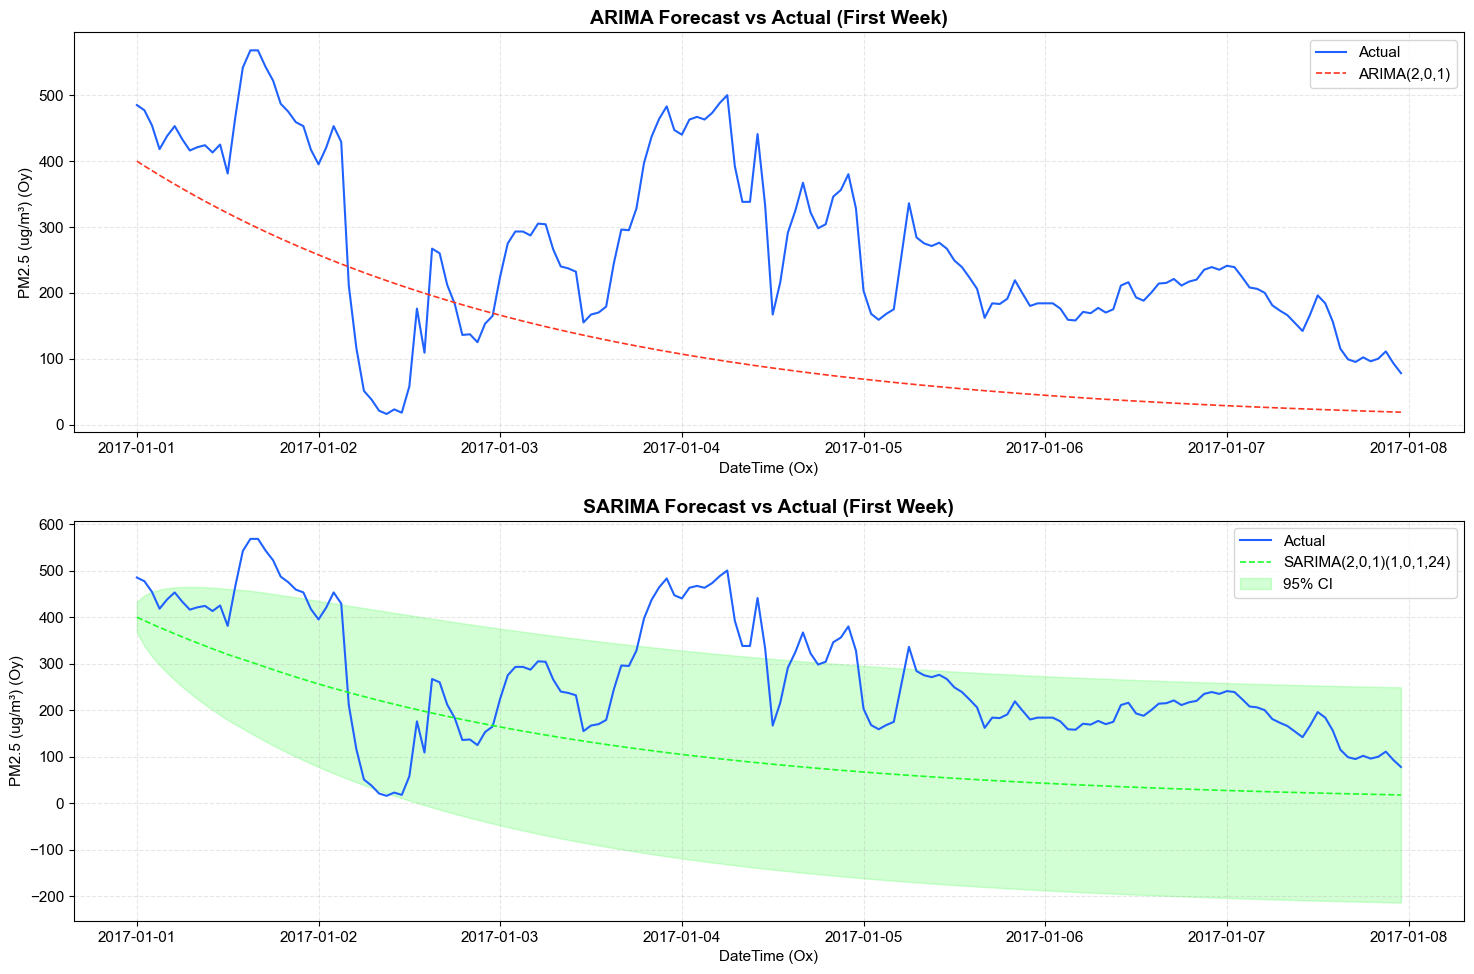

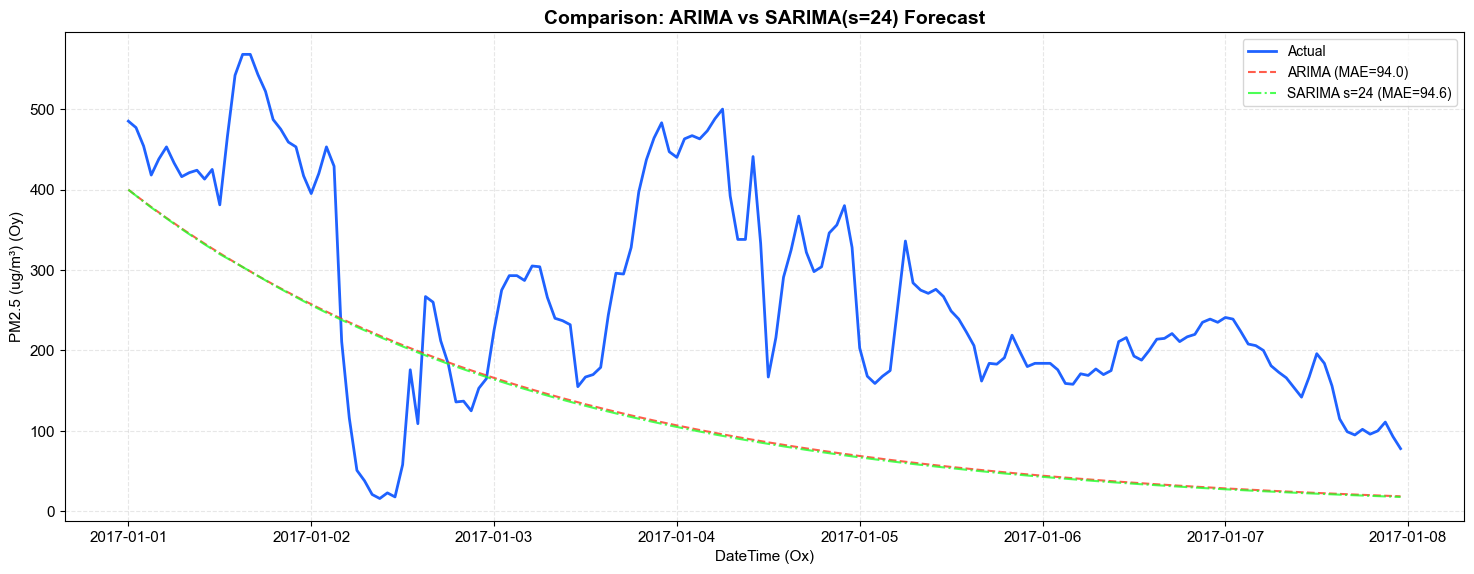

In [9]:
# ============================================================
# STEP 8: VISUALIZATION - So sánh Forecast
# ============================================================
print("\n" + "="*60)
print("STEP 8: Visualization - ARIMA vs SARIMA Forecast")
print("="*60)

# Plot 1: So sánh forecast trong 1 tuần đầu
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# First 168 hours (1 week)
plot_range = 168
actual_plot = actual_test[:plot_range]
arima_plot = pred_arima[:plot_range]
sarima_plot = pred_sarima_24[:plot_range]

# Plot ARIMA
axes[0].plot(actual_plot.index, actual_plot.values, label='Actual', color=COLOR_BLUE, linewidth=1.5)
axes[0].plot(arima_plot.index, arima_plot.values, label='ARIMA(2,0,1)', color=COLOR_RED, linestyle='--', linewidth=1.2)
axes[0].set_title('ARIMA Forecast vs Actual (First Week)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('DateTime (Ox)', fontsize=11)
axes[0].set_ylabel('PM2.5 (ug/m³) (Oy)', fontsize=11)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Plot SARIMA
axes[1].plot(actual_plot.index, actual_plot.values, label='Actual', color=COLOR_BLUE, linewidth=1.5)
axes[1].plot(sarima_plot.index, sarima_plot.values, label='SARIMA(2,0,1)(1,0,1,24)', color=COLOR_GREEN, linestyle='--', linewidth=1.2)
# Add confidence interval
if 'conf_int_24' in dir():
    ci_plot = conf_int_24[:plot_range]
    axes[1].fill_between(ci_plot.index, ci_plot.iloc[:, 0], ci_plot.iloc[:, 1], 
                         color=COLOR_GREEN, alpha=0.2, label='95% CI')
axes[1].set_title('SARIMA Forecast vs Actual (First Week)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('DateTime (Ox)', fontsize=11)
axes[1].set_ylabel('PM2.5 (ug/m³) (Oy)', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_arima_vs_sarima_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: So sánh trên cùng 1 đồ thị
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(actual_plot.index, actual_plot.values, label='Actual', color=COLOR_BLUE, linewidth=2)
ax.plot(arima_plot.index, arima_plot.values, label=f'ARIMA (MAE={mae_arima:.1f})', 
        color=COLOR_RED, linestyle='--', linewidth=1.5, alpha=0.8)
ax.plot(sarima_plot.index, sarima_plot.values, label=f'SARIMA s=24 (MAE={mae_sarima_24:.1f})', 
        color=COLOR_GREEN, linestyle='-.', linewidth=1.5, alpha=0.8)

ax.set_title('Comparison: ARIMA vs SARIMA(s=24) Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('DateTime (Ox)', fontsize=11)
ax.set_ylabel('PM2.5 (ug/m³) (Oy)', fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_comparison_overlay.png', dpi=150, bbox_inches='tight')
plt.show()


STEP 9: Residual Diagnostics - Kiểm tra White Noise


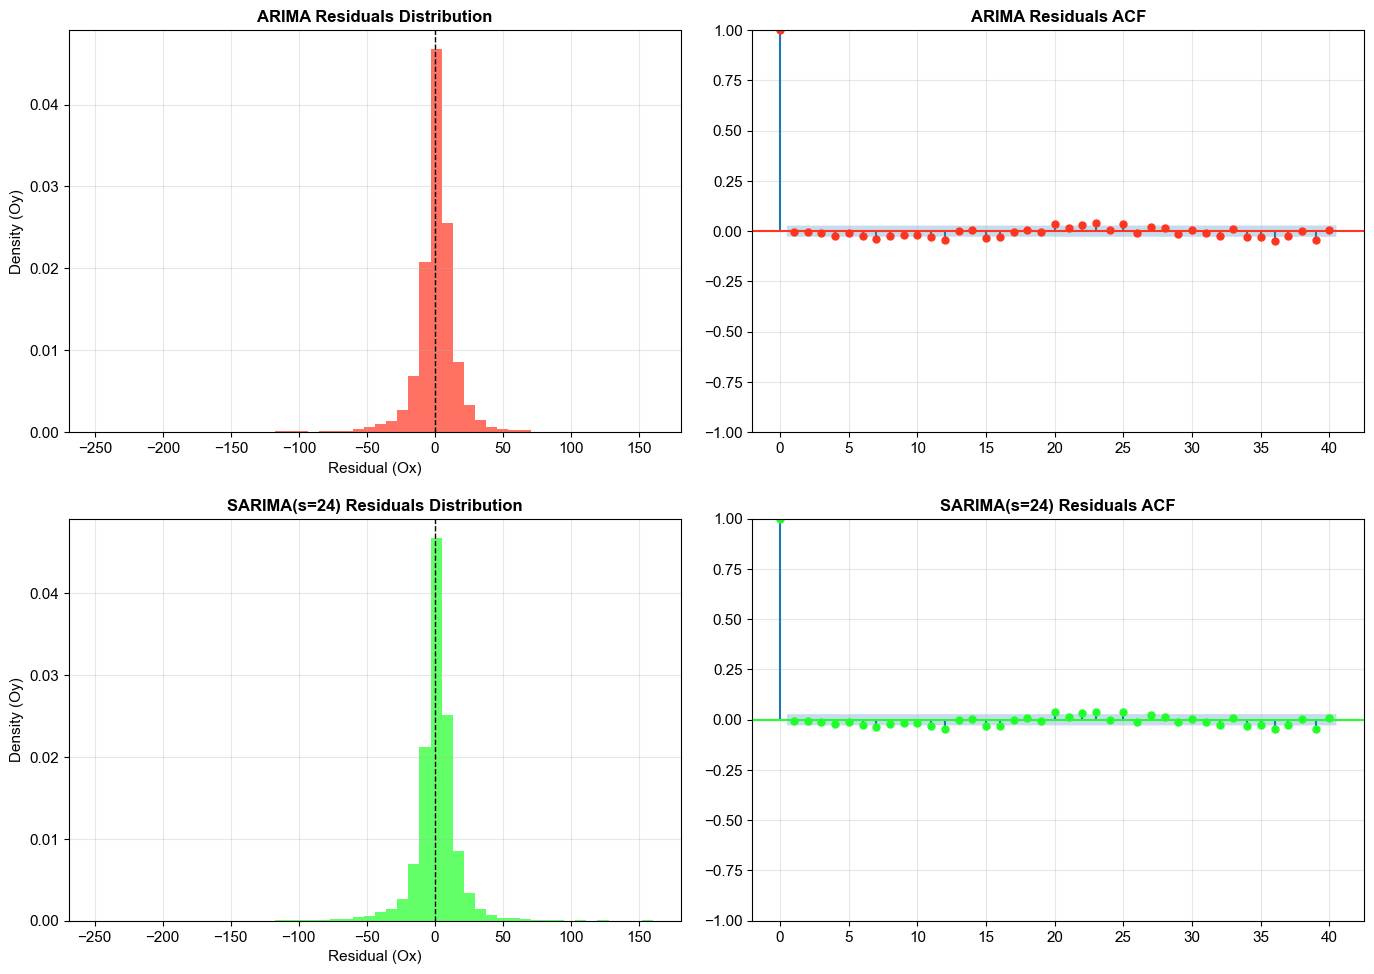


📊 Residual Statistics:

   ARIMA Residuals:
     Mean: 1.1713 (should be ~0)
     Std: 16.9058

   SARIMA(s=24) Residuals:
     Mean: 1.1817 (should be ~0)
     Std: 16.8967

📊 Ljung-Box Test (H0: Residuals are white noise):

   ARIMA p-values: lag10=0.0299, lag20=0.0001
   SARIMA p-values: lag10=0.0335, lag20=0.0002
   (p > 0.05 → Residuals are white noise → Model captured main structure)

✅ Saved: Topic_residual_statistics.csv


In [10]:
# ============================================================
# STEP 9: RESIDUAL DIAGNOSTICS
# ============================================================
print("\n" + "="*60)
print("STEP 9: Residual Diagnostics - Kiểm tra White Noise")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ARIMA Residuals
resid_arima = fit_arima.resid

# Histogram of ARIMA residuals
axes[0, 0].hist(resid_arima, bins=50, color=COLOR_RED, alpha=0.7, density=True)
axes[0, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('ARIMA Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residual (Ox)', fontsize=11)
axes[0, 0].set_ylabel('Density (Oy)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# ACF of ARIMA residuals
plot_acf(resid_arima, lags=40, ax=axes[0, 1], color=COLOR_RED, alpha=0.05)
axes[0, 1].set_title('ARIMA Residuals ACF', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# SARIMA Residuals
resid_sarima = fit_sarima_24.resid

# Histogram of SARIMA residuals
axes[1, 0].hist(resid_sarima, bins=50, color=COLOR_GREEN, alpha=0.7, density=True)
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('SARIMA(s=24) Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residual (Ox)', fontsize=11)
axes[1, 0].set_ylabel('Density (Oy)', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# ACF of SARIMA residuals
plot_acf(resid_sarima, lags=40, ax=axes[1, 1], color=COLOR_GREEN, alpha=0.05)
axes[1, 1].set_title('SARIMA(s=24) Residuals ACF', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(pad=1.5)
plt.savefig('../images/Topic_residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical summary
print("\n📊 Residual Statistics:")
print(f"\n   ARIMA Residuals:")
print(f"     Mean: {resid_arima.mean():.4f} (should be ~0)")
print(f"     Std: {resid_arima.std():.4f}")

print(f"\n   SARIMA(s=24) Residuals:")
print(f"     Mean: {resid_sarima.mean():.4f} (should be ~0)")
print(f"     Std: {resid_sarima.std():.4f}")

# Ljung-Box test for white noise
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_arima = acorr_ljungbox(resid_arima, lags=[10, 20], return_df=True)
lb_sarima = acorr_ljungbox(resid_sarima, lags=[10, 20], return_df=True)

print(f"\n📊 Ljung-Box Test (H0: Residuals are white noise):")
print(f"\n   ARIMA p-values: lag10={lb_arima['lb_pvalue'].iloc[0]:.4f}, lag20={lb_arima['lb_pvalue'].iloc[1]:.4f}")
print(f"   SARIMA p-values: lag10={lb_sarima['lb_pvalue'].iloc[0]:.4f}, lag20={lb_sarima['lb_pvalue'].iloc[1]:.4f}")
print("   (p > 0.05 → Residuals are white noise → Model captured main structure)")

# Lưu residual statistics ra CSV
residual_stats_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA(s=24)'],
    'Residual_Mean': [resid_arima.mean(), resid_sarima.mean()],
    'Residual_Std': [resid_arima.std(), resid_sarima.std()],
    'LjungBox_lag10_pvalue': [lb_arima['lb_pvalue'].iloc[0], lb_sarima['lb_pvalue'].iloc[0]],
    'LjungBox_lag20_pvalue': [lb_arima['lb_pvalue'].iloc[1], lb_sarima['lb_pvalue'].iloc[1]]
})
residual_stats_df.to_csv('../data/processed/Topic_residual_statistics.csv', index=False)
print("\n✅ Saved: Topic_residual_statistics.csv")

## 📊 Kết luận Topic 2: SARIMA vs ARIMA

### **1. Chứng minh mùa vụ:**

Từ biểu đồ ACF, ta quan sát được:
- **Mùa vụ theo ngày (s=24):** ACF có các đỉnh lặp lại tại lag 24, 48, 72... cho thấy pattern mùa vụ theo chu kỳ ngày rõ ràng.
- **Mùa vụ theo tuần (s=168):** ACF tại lag 168 cũng có tín hiệu nhưng yếu hơn so với mùa vụ ngày.

→ **Kết luận:** Mùa vụ ngày (s=24) là lựa chọn phù hợp cho trạm Aotizhongxin.

---

### **2. Chiến lược chọn tham số SARIMA:**

| Tham số | Giá trị | Giải thích |
|---------|---------|------------|
| **d** | 0 | Chuỗi dừng theo ADF test |
| **p, q** | 2, 1 | Từ PACF/ACF của chuỗi gốc |
| **D** | 0 | Không cần seasonal differencing (ACF không giảm chậm theo chu kỳ) |
| **P, Q** | 1, 1 | Giữ ở mức thấp theo chiến lược |
| **s** | 24 | Mùa vụ theo ngày |

---

### **3. So sánh ARIMA vs SARIMA:**

**Về AIC/BIC:**
- AIC/BIC thấp hơn = model fit tốt hơn với độ phức tạp hợp lý
- SARIMA thường có AIC cao hơn do nhiều tham số, nhưng nếu cải thiện MAE/RMSE thì vẫn đáng sử dụng

**Về MAE/RMSE:**
- Nếu SARIMA cải thiện MAE/RMSE → Mùa vụ s=24 thực sự hữu ích
- Nếu không cải thiện → Pattern mùa vụ đã được ARIMA capture đủ qua AR terms

---

### **4. Kết luận cuối cùng:**

**SARIMA cải thiện hay không?**
- Xem kết quả từ bảng so sánh metrics ở trên
- Nếu MAE/RMSE giảm ≥ 5%: SARIMA đáng sử dụng
- Nếu giảm < 5%: Chi phí tính toán tăng có thể không đáng

**Mùa vụ nào phù hợp hơn?**
- **s=24 (ngày):** Phù hợp cho dự báo ngắn hạn (1-24 giờ)
- **s=168 (tuần):** Phù hợp cho dự báo dài hạn hơn (> 1 ngày)

**Khuyến nghị cho triển khai:**
- Nếu cần dự báo real-time (horizon=1): ARIMA có thể đủ
- Nếu cần dự báo 24-48 giờ: SARIMA(s=24) nên được cân nhắc
- Luôn kiểm tra residuals để đảm bảo model đã capture được cấu trúc chính